In [27]:
client.restart()

Client Scheduler: tcp://scheduler:8786 Dashboard: http://scheduler:8787,Cluster Workers: 1 Cores: 4 Memory: 16.81 GB


In [1]:
%matplotlib inline
%load_ext memory_profiler

import matplotlib.pyplot as plt
from dask.dot import dot_graph
import itertools
import logging
import netCDF4
import numpy as np
import dask.array as da
from dask import delayed
import time
from dask.distributed import Client
from urllib import request


client = Client('scheduler:8786')
#client = Client(processes=False)

download_location = '/temp'
data_url = 'http://172.21.0.1:8080'
max_download_attempts = 5

all_models = ['ACCESS1-0', 'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM-CHEM', 'MIROC-ESM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'bcc-csm1-1', 'inmcm4']
all_models = ['ACCESS1-0'] 
all_vars = ['tasmax', 'pr']
all_years = {
     # 'historical': list(range(1971, 1976))
    'historical': [1971, 1973, 1974, 1975, 1977, 1978, 1979, 1981]
}

def get_dataset_url(variable, scenario, model, year, prefix = data_url):
    prefix_filename = '/'.join([prefix, 'NEX-GDDP', 'BCSD', scenario, 'day', 'atmos', variable, 'r1i1p1', 'v1.0'])
    prefix_filename = data_url + '/data'
    filename = '_'.join([variable, 'day', 'BCSD', scenario, 'r1i1p1', model, str(year) + '.nc'])
    url = '/'.join([prefix_filename, filename])
    return url

def get_context(year, **kwargs):
    variables = [kwargs.get('variable')] if kwargs.get('variable') else all_vars
    scenarios = ['historical']
    models = [kwargs.get('model')] if kwargs.get('model') else all_models
    outlist = []
    combinations = list(itertools.product(variables, scenarios, models))
    result = list(map(lambda comb: [ *comb, year ], combinations))
    return result

def get_year_ensemble(year, variable = 'tasmax'):
    context = get_context(year, variable = variable)
    datasets = list(map(lambda x: str(get_dataset_url(*x)), context))
    return datasets

def to_dataset(filename):
    return netCDF4.Dataset(filename)

def download_file(url):
    print("url: " + url)
    attempts = 0
    success = False
    filename = ""
    while attempts < max_download_attempts and not success:
        time.sleep(2 ** attempts)
        filename = '/'.join([download_location, str(url.split('/')[-1])])
        print("Downloading file at " + filename)
        u = request.urlopen(url)
        f = open(filename, 'wb')
        f.write(u.read())
        f.close()
        success = True
        break
    return filename

"OK"

'OK'

In [2]:
client.ncores()

{'tcp://172.21.0.3:41711': 4}

In [3]:
datasets_tasmax = list(map(get_year_ensemble, all_years['historical']))
datasets_pr = list(map(lambda x : get_year_ensemble(x, variable = 'pr'), all_years['historical']))
datasets_tasmax

[['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1971.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1973.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1974.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1975.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1977.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1978.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1979.nc'],
 ['http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1981.nc']]

In [4]:
dsets = []
for row in datasets_tasmax:
    print("Processing year")
    fnames = list(map(download_file, row))
    datasets_year = list(map(lambda dset: netCDF4.Dataset(dset)['tasmax'], fnames))
    dsets.append(datasets_year)

dsets

Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1971.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1973.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1974.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1975.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1977.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1978.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1979.nc
Processing year
url: http://172.21.0.1:8080/data/tasmax_day_BCSD_historical_r1i1p1_ACCESS1-0_1981.nc


[[<class 'netCDF4._netCDF4.Variable'>
  float32 tasmax(time, lat, lon)
      time: 719162.5
      standard_name: air_temperature
      long_name: Daily Maximum Near-Surface Air Temperature
      units: K
      cell_methods: time: maximum
      cell_measures: area: areacella
      history: 2012-01-17T09:46:42Z altered by CMOR: Treated scalar dimension: 'height'. 2012-01-17T09:46:42Z altered by CMOR: replaced missing value flag (-1.07374e+09) with standard missing value (1e+20).
      coordinates: height
      missing_value: 1e+20
      associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_ACCESS1-0_historical_r0i0p0.nc areacella: areacella_fx_ACCESS1-0_historical_r0i0p0.nc
      _FillValue: 1e+20
  unlimited dimensions: time
  current shape = (365, 720, 1440)
  filling on], [<class 'netCDF4._netCDF4.Variable'>
  float32 tasmax(time, lat, lon)
      time: 719162.5
      standard_name: air_temperature
      long_name: Daily Maximum Near-S

In [5]:
stack = da.concatenate([dset[0] for dset in dsets], axis = 0)
stack

dask.array<concatenate, shape=(2920, 720, 1440), dtype=float32, chunksize=(365, 720, 1440)>

In [6]:
stack_rechunked = stack.rechunk((2920, 72, 72))
stack_rechunked

dask.array<rechunk-merge, shape=(2920, 720, 1440), dtype=float32, chunksize=(2920, 72, 72)>

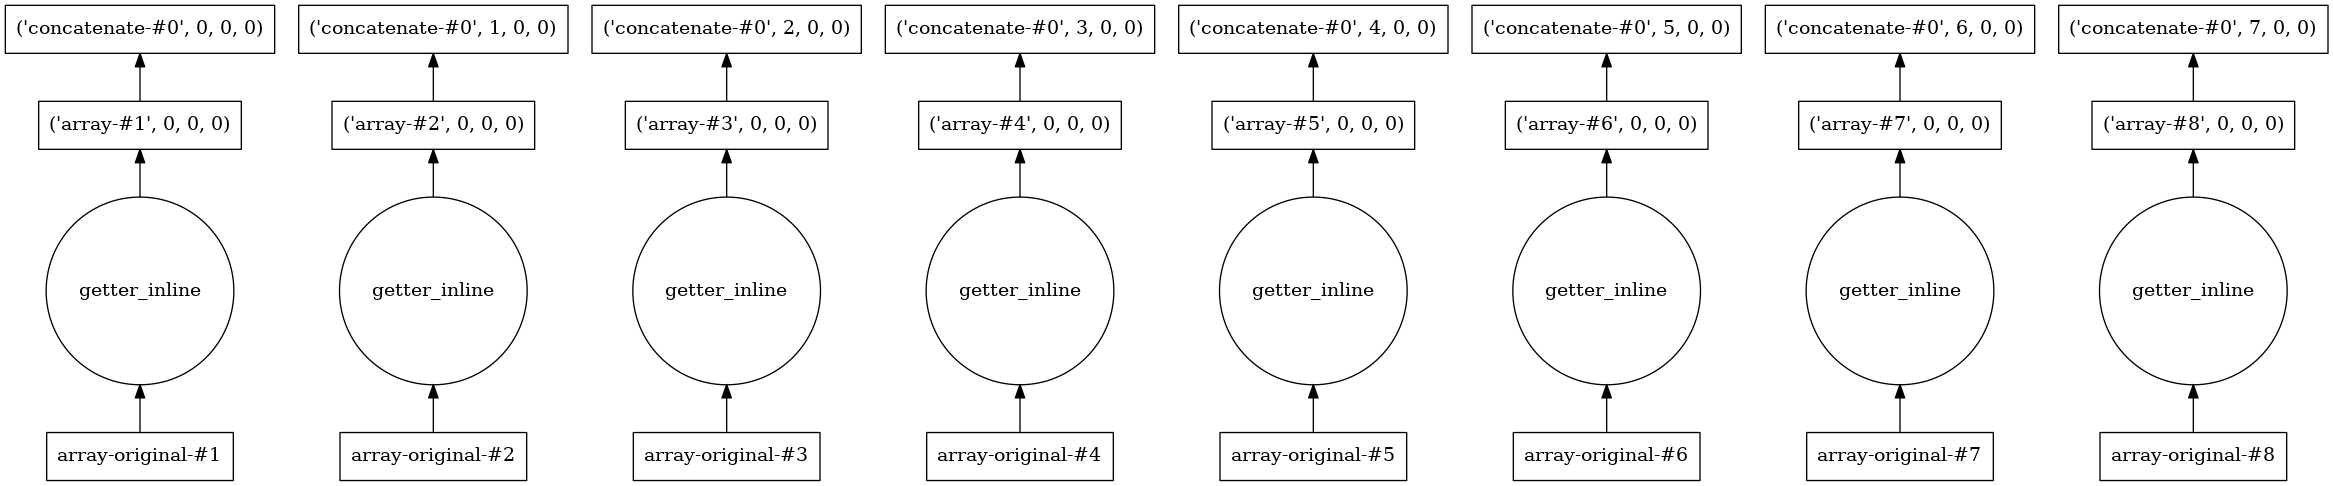

In [7]:
dot_graph(stack.dask)

In [12]:
%%timeit

block = stack[:, 0:180, 0:180]
res = np.percentile(block, 99, axis = 0)
res

9.57 s ± 91.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
def per_ch_sz(chsize):
    randarr = np.random.randn(10958, chsize, chsize)
    res = np.percentile(randarr, 99, axis = 0)
    return res

In [38]:
%memit per_ch_sz(144)

peak memory: 5302.66 MiB, increment: 3467.21 MiB


In [40]:
%timeit per_ch_sz(144)

25.5 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%memit per_ch_sz(180)

peak memory: 7252.93 MiB, increment: 5417.46 MiB


In [41]:
%timeit per_ch_sz(180) # Not much difference

38.2 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
result = per_ch_sz(144)
result

array([[ 2.36072039,  2.34604781,  2.34715941, ...,  2.30323546,
         2.31736336,  2.29898659],
       [ 2.33111657,  2.29906501,  2.36533776, ...,  2.32299113,
         2.30521977,  2.34011111],
       [ 2.26640866,  2.27319486,  2.32159715, ...,  2.38726368,
         2.32420863,  2.28883504],
       ..., 
       [ 2.297956  ,  2.30421491,  2.29570811, ...,  2.36992701,
         2.32451963,  2.32464274],
       [ 2.34414298,  2.36880538,  2.30323059, ...,  2.35225677,
         2.25319916,  2.38294391],
       [ 2.37784139,  2.34852161,  2.38625024, ...,  2.28119774,
         2.32207665,  2.27839109]])

In [74]:
def get_stacks(a, chunksize):
    time, lat, lon = a.shape
    nstacks_lat = int(np.ceil(lat / chunksize))
    nstacks_lon = int(np.ceil(lon / chunksize))
    
    stacks = []
    
    for i in range(nstacks_lat):
        for j in range(nstacks_lon):
            latmin, latmax = i * chunksize, (i+1) * chunksize
            lonmin, lonmax = j * chunksize, (j+1) * chunksize
            print(i, j, '~>', latmin, latmax, lonmin, lonmax)
            stacked = a[:, latmin:latmax, lonmin:lonmax]
            print(stacked)
            stacks.append(stacked)
    return stacks
stacks = get_stacks(stack, 144)
res = list(map(lambda x: np.percentile(x, 99, axis=0), stacks))
res

0 0 ~> 0 144 0 144
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 1 ~> 0 144 144 288
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 2 ~> 0 144 288 432
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 3 ~> 0 144 432 576
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 4 ~> 0 144 576 720
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 5 ~> 0 144 720 864
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 6 ~> 0 144 864 1008
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 7 ~> 0 144 1008 1152
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 8 ~> 0 144 1152 1296
dask.array<getitem, shape=(2920, 144, 144), dtype=float32, chunksize=(365, 144, 144)>
0 9 ~> 0 144 1296 1440
dask.array<

[array([[ 277.03999542,  277.07469757,  277.02085175, ...,  277.16198792,
          277.10042999,  277.06144318],
        [ 277.08513916,  277.10594147,  277.11808899, ...,  277.26519714,
          277.29007538,  277.32355804],
        [ 276.96750916,  276.98441742,  277.00271667, ...,  277.11339203,
          277.13372253,  277.15595978],
        ..., 
        [ 270.04126831,  270.04851013,  270.19499817, ...,  270.73677216,
          270.74702301,  270.74545288],
        [ 270.14920746,  270.15800293,  270.29177338, ...,  270.84039307,
          270.83009613,  270.83519653],
        [ 270.28214966,  270.2784787 ,  270.39348602, ...,  270.97476288,
          270.98250336,  270.97748291]]),
 array([[ 277.0686377 ,  277.10813904,  277.13016998, ...,  277.32416382,
          277.320625  ,  277.29108063],
        [ 277.30187439,  277.32321625,  277.34864319, ...,  277.3664447 ,
          277.35707214,  277.35322693],
        [ 277.1936441 ,  277.25470917,  277.2834549 , ...,  277.45731812

In [75]:
int(np.sqrt(len(res) / 2))

5

In [123]:
slices = [res[i:i + 5] for i in range(1, 50, 5) ]
stacked_lons= list(map(np.hstack, slices))
print(list(map(np.shape, stacked_lons)))
stacked_lats = np.vstack(stacked_lons[0:9])
stacked_lats.shape

[(144, 720), (144, 720), (144, 720), (144, 720), (144, 720), (144, 720), (144, 720), (144, 720), (144, 720), (144, 576)]


(1296, 720)

In [125]:
np.amax(stacked_lats)

1.0000000200408773e+20